# <B> Fama French 3 Factor Analysis

In [1]:
import pandas as pd                     
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt                      #importing necessary libraries - modules
import pandas_datareader.data as web
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
start = dt.date(2018,8,1)  #setting the start and the end dates which are going to help me in the process of importing web data
end = dt.date(2021,9,1)    # for FF3FM factors

### Inserting the Factors data for FF3FM

In [3]:
factors = web.DataReader("F-F_Research_Data_Factors_Daily", "famafrench", start, end)[0]  # Importing the FF3FM daily factors
                                                                                          # data the provided website

In [4]:
factors.index = pd.to_datetime(factors.index, format="%Y%m%d")   # setting up the index (date) of the factors table to DateTime 
                                                                 # format

In [5]:
factors = factors.resample('BM').mean()  # getting monthly average for the factors data

<AxesSubplot:xlabel='Date'>

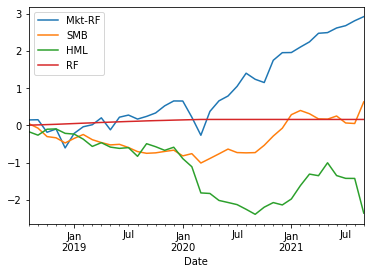

In [6]:
factors_cum = factors.cumsum()     # calculating the cumulative sum of the factors data
factors_cum.plot.line()          # plotting the factors data (Mkt-RF, SMB, HML, RF) in order to see the trend for the period 
                                 # between start and end date (01.08.2018 - 01.09.2021)

### <B> Importing the companies' time series data 

In [7]:
df = pd.read_excel('final_yahoo_data.xlsx')
df = df.set_index('Date')      # setting the Date column as an index, which later will help us

Now, we have our data for the companies we have, and our data is quite accurate as I extracted this data from **Yahoo Finance**. 
So, we have quite few missing data which I did impelement replacing this few missing data with previous values. So, by now our 
data looks fine to proceed with our **Fama French 3 Factor Model analysis** and implementing the OLS (Ordinary Least Squares)
regression. As a final output, I am going to extract each companies' (assets') "Required rate of return" which is going to be 
extracted to excel file. 

Our function for FF3FM is:     **RRR = Rf + β1*(Rm-Rf) + β2*SMB + β3*HML**

Next, I am going to find the FF3FM parameters and then plug them into the function above

In [8]:
column_name = df.columns.to_list()  # as our column headers represent the companies, creating a list consisting of column names
                                    # /asset names will help us to iterate through when finding RRR

I am going to define a function which will return us the Required Rate of Return for each company. It might seem a bit complex
but I am going to try to make it understandable through comments.

In [9]:
def required_rate_return(a):           
    asset = pd.DataFrame(df[a])            # setting up a Dataframe for the asset(or company) we would like to find RRR.
    asset.index= pd.to_datetime(asset.index, format="%Y%m%d")    #setting up the dataframe index to datetime format 

    monthly_price = asset.resample('BM').last()         # resampling by the latest monthly price
    monthly_returns = monthly_price.pct_change().dropna()   #calculating the log or percentage change for each row (date)
    excess_returns = (monthly_returns[a] - factors['RF']).dropna()    # calculating the excess monthly returns

    excess_returns = pd.DataFrame(data=excess_returns.values,         # converting to Dataframe
                                  index=excess_returns.index,
                                  columns=["Returns"])
    excess_returns_cum = excess_returns.cumsum()

    data = factors.join(excess_returns).dropna()            # joining factors in order to run the OLS regression
    y = data[["Returns"]] 
    x = data[["Mkt-RF","SMB","HML"]]


    ols = sm.OLS(y,x)

    result = ols.fit()
    betas = result.params

    latest_factors = factors.tail(1).to_dict('records')[0]

    RRR = latest_factors["RF"]                               # calculating the RRR by implementing the each step of the FF3FM
    RRR += betas["Mkt-RF"] * latest_factors["Mkt-RF"]        # model  
    RRR += betas["SMB"] * latest_factors["SMB"]
    RRR += betas["HML"] * latest_factors["HML"]
    
    print(f"Required rate of return for asset",a, f"is: {RRR}")
    
    return RRR


In [10]:
list_rrr = []                # creating an empty list which the RRR of each asset will later be collected in it

In [11]:
for i in range(len(column_name)):
    b = required_rate_return(column_name[i])      #now we run our required_rate_return function collectively for each company
    list_rrr.append(b)                            # then appending this data into the previously created list     

Required rate of return for asset 000503.SZ is: -0.04278045826206287
Required rate of return for asset 002022.SZ is: 0.028077204394743756
Required rate of return for asset 002625.SZ is: -0.01384548659816938
Required rate of return for asset 002693.SZ is: 0.005663342043928168
Required rate of return for asset 002777.SZ is: 0.005073183425078651
Required rate of return for asset 002897.SZ is: 0.004892549849196931
Required rate of return for asset 0383.HK is: -0.030807812464294218
Required rate of return for asset 068270.KS is: 0.09402598627417114
Required rate of return for asset 069620.KS is: 0.0928101541344627
Required rate of return for asset 078520.KS is: 0.027613284454829044
Required rate of return for asset 0853.HK is: 0.22253882605432088
Required rate of return for asset 1161.HK is: -0.11398109129623762
Required rate of return for asset 1521.HK is: 0.13218187853508576
Required rate of return for asset 1548.HK is: -0.1290230500552642
Required rate of return for asset 1652.HK is: -0.

Required rate of return for asset AVEO is: 0.03659821536325932
Required rate of return for asset AVXL is: 0.20072359586165112
Required rate of return for asset AXDX is: 0.16983838525780826
Required rate of return for asset AXGN is: 0.07241671195871266
Required rate of return for asset AXNX is: 0.10306094982489979
Required rate of return for asset AYTU is: 0.3114790701165845
Required rate of return for asset BABA is: 0.09479732036143167
Required rate of return for asset BAS.DE is: 0.0048848817581712
Required rate of return for asset BAYRY is: 0.026056398888594567
Required rate of return for asset BCLI is: 0.18730519095061515
Required rate of return for asset BDSI is: -0.00825031419080919
Required rate of return for asset BDX is: 0.01496794987683362
Required rate of return for asset BGNE is: 0.14536923395510626
Required rate of return for asset BH.BK is: -0.0181151824240557
Required rate of return for asset BHVN is: 0.05766885908879242
Required rate of return for asset BIDU is: 0.1890388

Required rate of return for asset GNPX is: 0.325781272332178
Required rate of return for asset GOOG is: -0.008319750011630553
Required rate of return for asset GSK is: -0.014743365450189796
Required rate of return for asset HALO is: 0.17476142345242554
Required rate of return for asset HARP is: 0.11938560990905232
Required rate of return for asset HCT.AX is: 0.08554476785157289
Required rate of return for asset HENKY is: -0.023743225459550682
Required rate of return for asset HEPA is: 0.12011191759282124
Required rate of return for asset HJLI is: 0.028503684737918707
Required rate of return for asset HMD.AX is: 0.008807722025566539
Required rate of return for asset HMS.ST is: 0.06493189310751779
Required rate of return for asset HNSA.ST is: 0.07760004583649187
Required rate of return for asset HROW is: -0.0346489437700597
Required rate of return for asset HRTX is: 0.11259865961751821
Required rate of return for asset HSIC is: -0.056534874193021736
Required rate of return for asset HSIT

Required rate of return for asset PCRX is: 0.03948979972576047
Required rate of return for asset PDCO is: -0.002172600895757479
Required rate of return for asset PEAK is: -0.038350468472951274
Required rate of return for asset PETQ is: 0.09405418891256506
Required rate of return for asset PETV is: 0.4105315418096278
Required rate of return for asset PFE is: -0.03791785385334643
Required rate of return for asset PHAS is: 0.11092294236481555
Required rate of return for asset PHG is: 0.022335277497147758
Required rate of return for asset PHLOG-B.ST is: -0.0318001731091066
Required rate of return for asset PHR is: 0.15565217960342956
Required rate of return for asset PLX is: 0.07803110715048096
Required rate of return for asset PMCB is: 0.31120034594315776
Required rate of return for asset PMD is: 0.03504382220043101
Required rate of return for asset POAI is: 0.10308318297987695
Required rate of return for asset POLX.L is: 0.007492307770549367
Required rate of return for asset PRLX is: -0.

Required rate of return for asset WVE is: 0.2578946151113296
Required rate of return for asset WZR.AX is: -0.12501189707248275
Required rate of return for asset XFOR is: -0.014910157009913355
Required rate of return for asset XGN is: -0.007625671358266084
Required rate of return for asset XOMA is: 0.1148511136274272
Required rate of return for asset XRAY is: -0.042403859165227015
Required rate of return for asset XTLB is: 0.06783159109831732
Required rate of return for asset ZBH is: 0.001038107237909272
Required rate of return for asset ZGNX is: 0.040823828724389805
Required rate of return for asset ZIVO is: -3.490424921388447
Required rate of return for asset ZLAB is: 0.20765666255804882
Required rate of return for asset ZSAN is: 0.3249939815954295
Required rate of return for asset ZTS is: -0.004375005399131417
Required rate of return for asset ZYNE is: -0.06474212512051715


In [12]:
new_df = pd.DataFrame()      # creating an empty DataFrame which we are going to merge asset name and RRR next to each other

In [13]:
new_df['Asset Name'] = column_name                   # as it is seen from the output, we now, have the Required Rate of Return 
new_df['Required_Rate_of_Return'] = list_rrr         # for each of the company we have.
new_df

,Asset Name,Required_Rate_of_Return
0,000503.SZ,-0.042780
1,002022.SZ,0.028077
2,002625.SZ,-0.013845
3,002693.SZ,0.005663
4,002777.SZ,0.005073
...,...,...
557,ZIVO,-3.490425
558,ZLAB,0.207657
559,ZSAN,0.324994
560,ZTS,-0.004375


In [15]:
new_df.to_excel('Final output.xlsx')      #exporting this final data to excel

I believe, now, we are done :)